In [1]:
import torch
import torch.nn as nn
#from .utils import load_state_dict_from_url
from typing import Any


try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    

    def get_features(self):
        return self.features


def alexnet(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> AlexNet:
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def load_test_img_cat():
    import os
    target = "cat.jpg"
    if os.path.exists(target):
        return target
    else:
        import urllib
        url, filename = ("https://raw.githubusercontent.com/mrqwertyuiop/Dog-Cat-Image-Classification---Machine-Learning-Model-CNN/master/cat1.jpg", target)
        try: urllib.URLopener().retrieve(url, filename)
        except: urllib.request.urlretrieve(url, filename)
    return target

def load_test_img():
    import os
    target = "dog.jpg"
    if os.path.exists(target):
        return target
    else:
        import urllib
        url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", target)
        try: urllib.URLopener().retrieve(url, filename)
        except: urllib.request.urlretrieve(url, filename)
    return target

In [2]:
model = alexnet(True,True)

def forward_model(model,isDog=True):
    
    if isDog:
        filename = load_test_img()
    else:
        filename = load_test_img_cat()

    from PIL import Image
    from torchvision import transforms
    input_image = Image.open(filename)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    # batch 1 , channel 3, length * width 224 * 224
    #print(input_batch.shape)
    #torch.Size([1, 3, 224, 224])

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes



    print(torch.argmax((torch.nn.functional.softmax(output[0], dim=0))))
    #print("all layers: ")
    ##for k,mod in model.features.named_children():
    #    print(k, mod)
    return


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_firstTwo_last_conv_filter(model):
    
    conv1 = dict(model.features.named_children())['0']
    conv2 = dict(model.features.named_children())['3']
    conv3 = dict(model.features.named_children())['6']
    conv4 = dict(model.features.named_children())['10']

    print("first layer:",conv1)
    print("second conv layer: ", conv2)
    print((conv1.weight.shape))

    plot_weights(conv1,  mean_input_channel=True)        
    plot_weights(conv2, mean_input_channel=True)
    #plot_weights(conv3, mean_input_channel=True)
    plot_weights(conv4, mean_input_channel=True)


def plot_weights(layer, mean_input_channel=False):
    
    num =  50 if layer.weight.shape[0] > 50 else layer.weight.shape[0]
    #print(layer.weight.shape[0])
    localw = layer.weight.cpu().clone()    
    if mean_input_channel:
        
        plt.figure(figsize=(20, 17))
        for i in range(1,num):
            localw0 = localw[i]
            #print("shape of filter: ", localw0.shape)
        
            if (len(localw0)) > 1:
                localw0 = torch.mean(localw0,dim=0)
                plt.subplot(9, 9, i+1) 
                plt.axis('off')
                plt.imshow(localw0[ :, :].detach(),cmap='gray')
            else:
                print("xxxx")
                plt.subplot(9, 9, i+1) 
                plt.axis('off')
                plt.imshow(localw0[0, :, :].detach(),cmap='gray')
            

    else:
            
        print("total of number of filter : ", len(localw))
        for i in range(1,num):
            localw0 = localw[i]
            #print(localw0.shape)    
            # mean of 3 channel.
            #localw0 = torch.mean(localw0,dim=0)
            # there should be 3(3 channels) 11 * 11 filter.
            plt.figure(figsize=(20, 17))
            if (len(localw0)) > 1:
                for idx, filer in enumerate(localw0):
                    plt.subplot(9, 9, idx+1) 
                    plt.axis('off')
                    plt.imshow(filer[ :, :].detach(),cmap='gray')
            else:
                    plt.subplot(9, 9, idx+1) 
                    plt.axis('off')
                    plt.imshow(localw0[0, :, :].detach(),cmap='gray')


In [4]:
#model = forward_model()
#plot_firstTwo_last_conv_filter(model)

tensor(281, device='cuda:0')
first layer: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
second conv layer:  Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
torch.Size([64, 3, 11, 11])


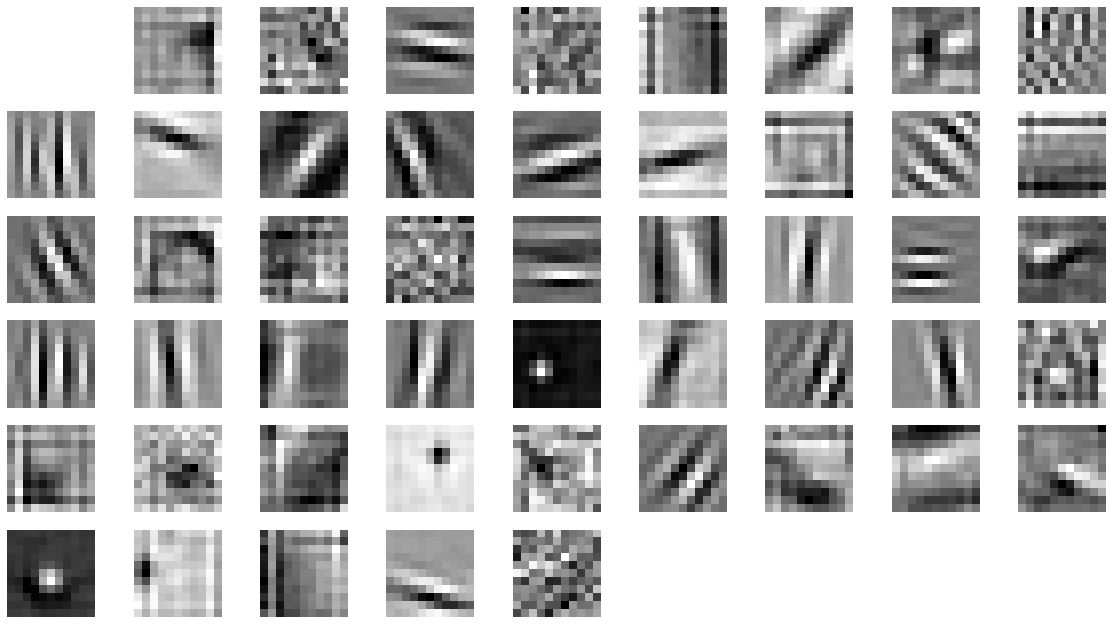

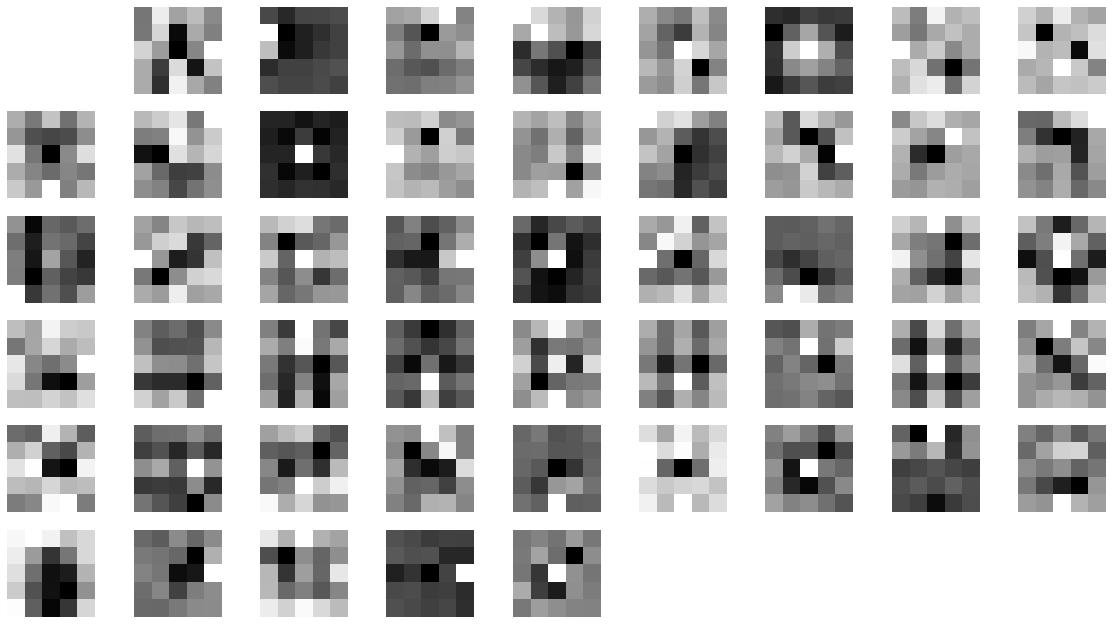

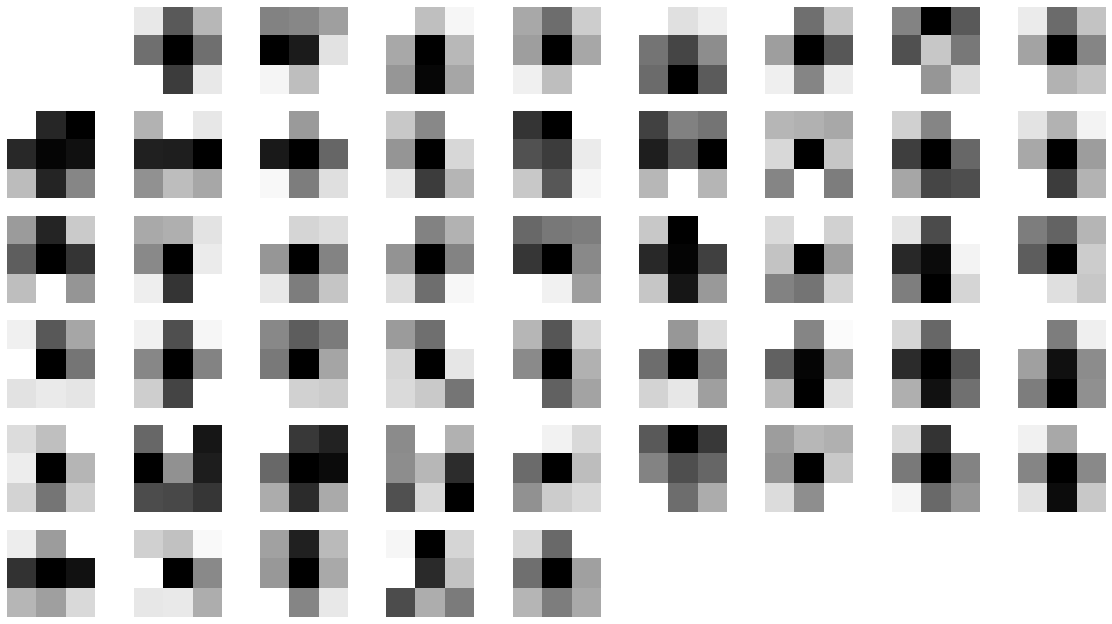

In [5]:
forward_model(model,False)
plot_firstTwo_last_conv_filter(model)

In [6]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [7]:

class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []


    def __call__(self,module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None
    

def plot_feature(model, idx):
    
    hh = Hook()
    model.features[idx].register_forward_hook(hh)
    
    forward_model(model,False)
    print(hh.module_name)
    print((hh.features_in_hook[0][0].shape))
    print((hh.features_out_hook[0].shape))
    
    out1 = hh.features_out_hook[0]

    total_ft  = out1.shape[1]
    first_item = out1[0].cpu().clone()    

    plt.figure(figsize=(20, 17))
    

    for ftidx in range(total_ft):
        if ftidx > 99:
            break
        ft = first_item[ftidx]
        plt.subplot(10, 10, ftidx+1) 
        
        plt.axis('off')
        #plt.imshow(ft[ :, :].detach(),cmap='gray')
        plt.imshow(ft[ :, :].detach())

hooker working <__main__.Hook object at 0x7ff77e126278>
tensor(281, device='cuda:0')
[<class 'torch.nn.modules.conv.Conv2d'>]
torch.Size([1, 3, 224, 224])
torch.Size([1, 64, 55, 55])


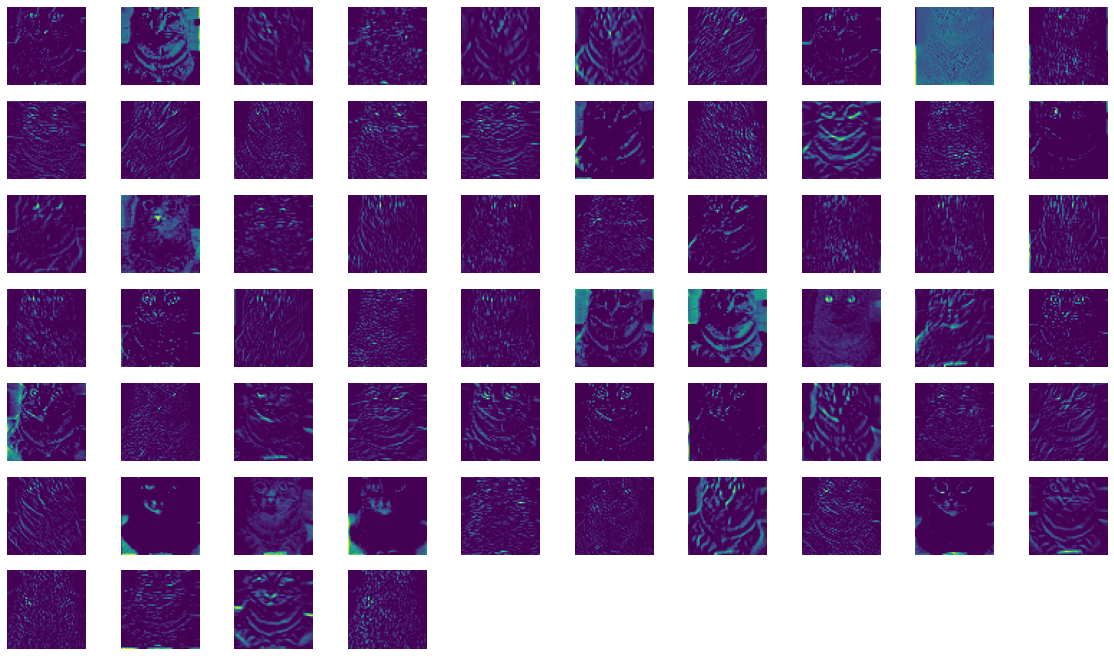

In [8]:
plot_feature(model, 0)


hooker working <__main__.Hook object at 0x7ff77e126278>
hooker working <__main__.Hook object at 0x7ff77e712668>
tensor(281, device='cuda:0')
[<class 'torch.nn.modules.conv.Conv2d'>]
torch.Size([1, 64, 27, 27])
torch.Size([1, 192, 27, 27])


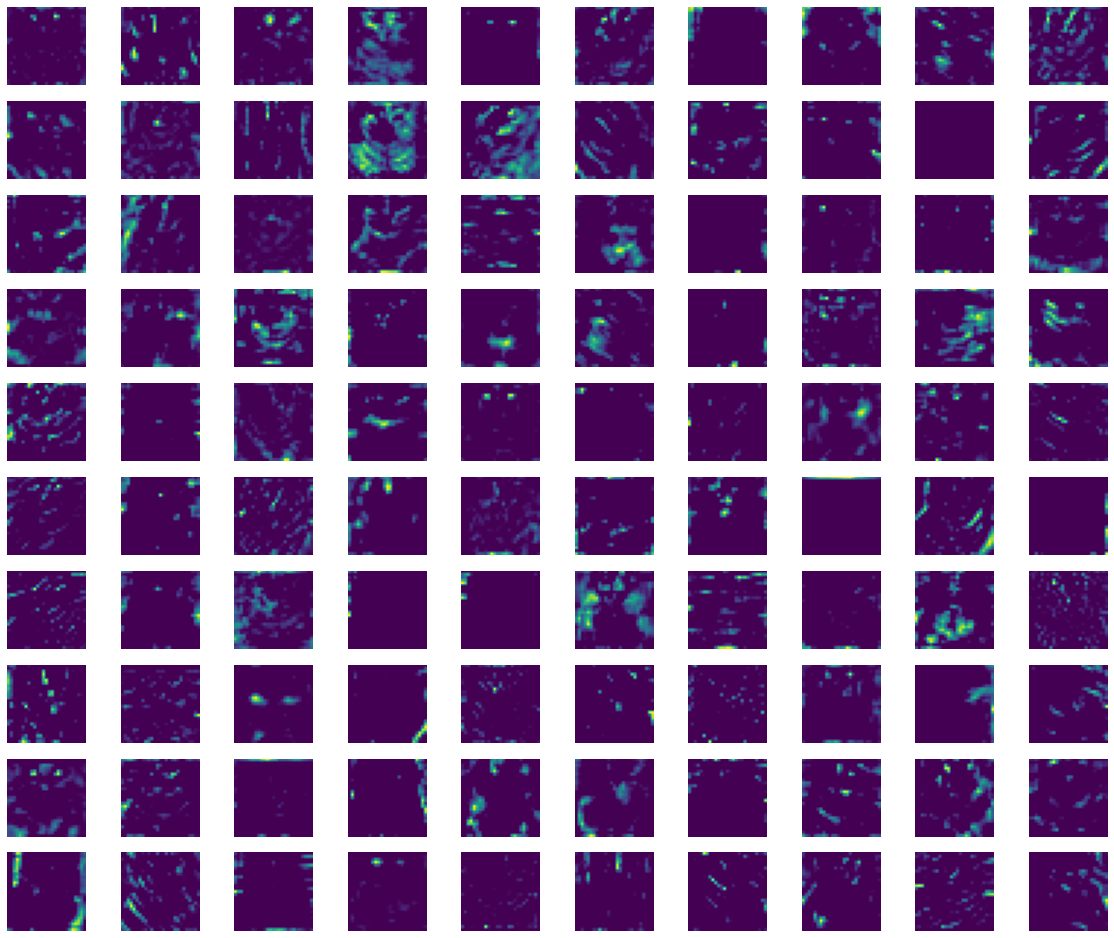

In [9]:
plot_feature(model, 3)

hooker working <__main__.Hook object at 0x7ff77e126278>
hooker working <__main__.Hook object at 0x7ff77e712668>
hooker working <__main__.Hook object at 0x7ff780135668>
tensor(281, device='cuda:0')
[<class 'torch.nn.modules.conv.Conv2d'>]
torch.Size([1, 192, 13, 13])
torch.Size([1, 384, 13, 13])


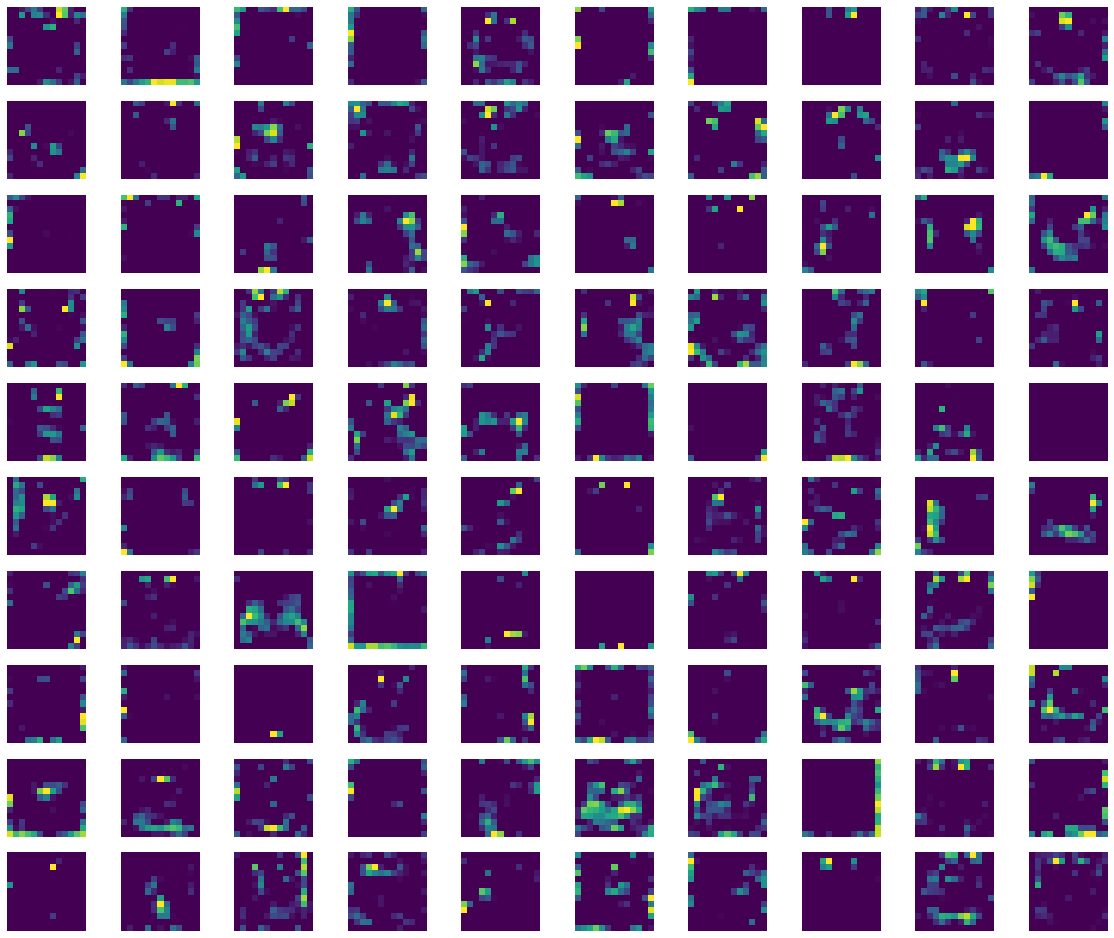

In [10]:
plot_feature(model, 6)

hooker working <__main__.Hook object at 0x7ff77e126278>
hooker working <__main__.Hook object at 0x7ff77e712668>
hooker working <__main__.Hook object at 0x7ff780135668>
hooker working <__main__.Hook object at 0x7ff77dad4b38>
tensor(281, device='cuda:0')
[<class 'torch.nn.modules.conv.Conv2d'>]
torch.Size([1, 384, 13, 13])
torch.Size([1, 256, 13, 13])


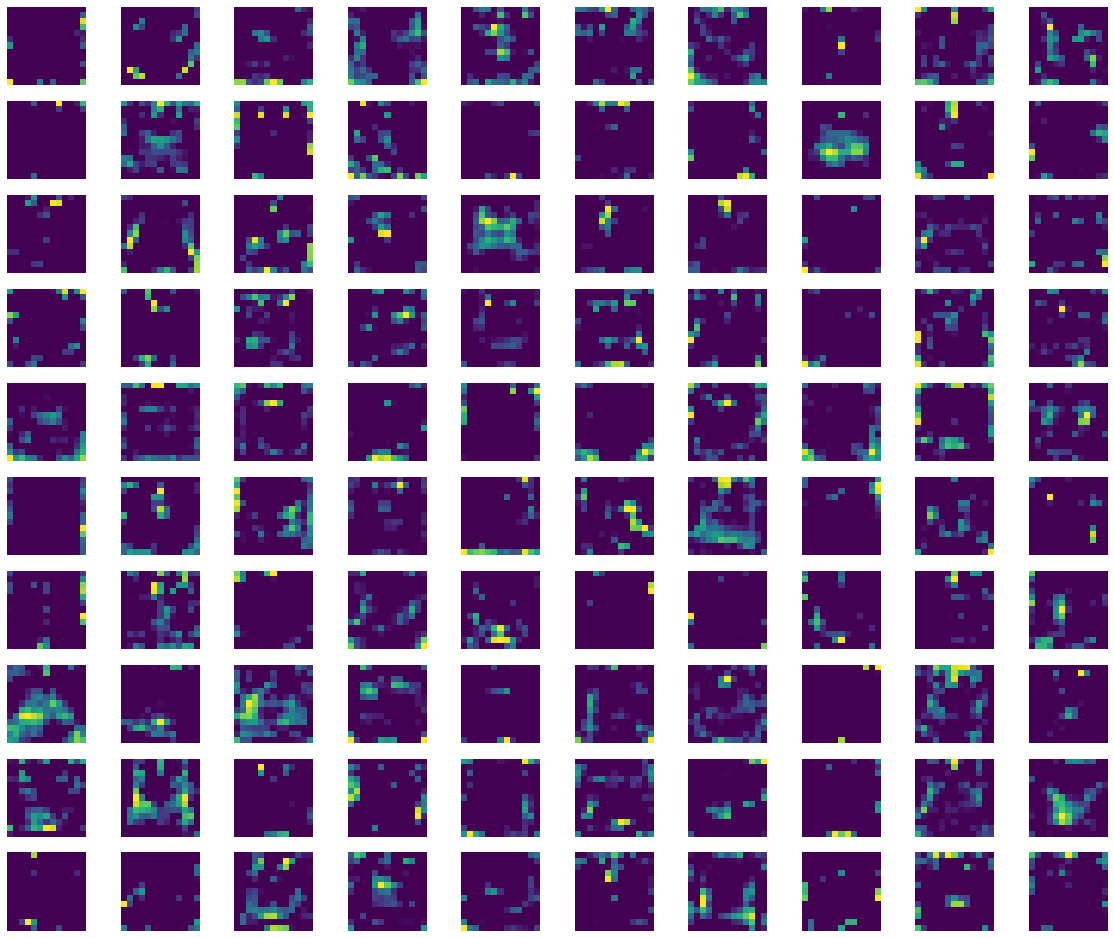

In [11]:
plot_feature(model, 8)

hooker working <__main__.Hook object at 0x7ff77e126278>
hooker working <__main__.Hook object at 0x7ff77e712668>
hooker working <__main__.Hook object at 0x7ff780135668>
hooker working <__main__.Hook object at 0x7ff77dad4b38>
hooker working <__main__.Hook object at 0x7ff77fb88128>
tensor(281, device='cuda:0')
[<class 'torch.nn.modules.conv.Conv2d'>]
torch.Size([1, 256, 13, 13])
torch.Size([1, 256, 13, 13])


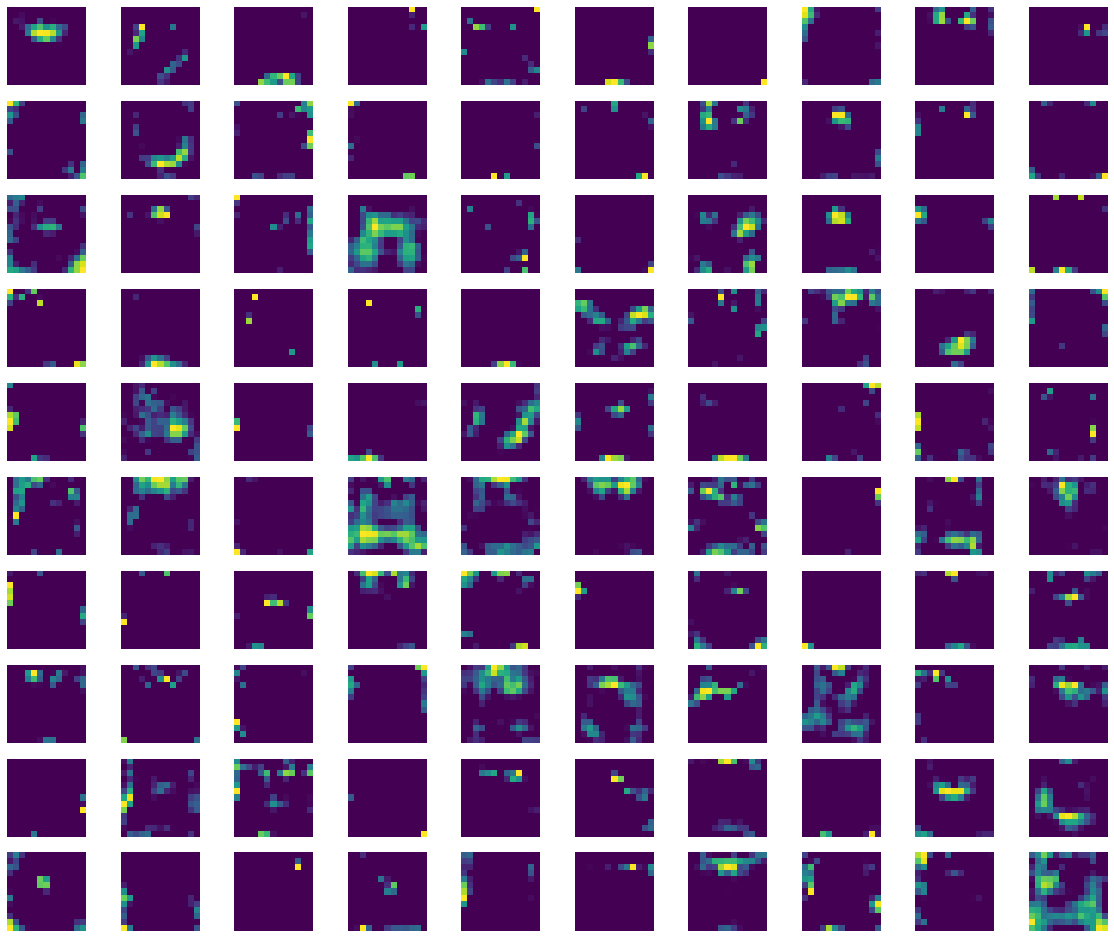

In [12]:
plot_feature(model, 10)